In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError, Huber,MeanAbsoluteError
from keras.layers import Dense, LSTM, Reshape,Dropout,Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


from vmdpy import VMD

from typing import List as List, Tuple as Tuple, Dict as Dict,Optional as Optional

2024-02-22 22:00:37.321408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 22:00:37.321548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 22:00:37.430316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_load = pd.read_csv("/mnt/e/github/load-forecast/01.database/processed/load/2022_2023_load_processed.csv", sep = ",", encoding = 'latin-1', index_col=0)
df_temp = pd.read_csv("/mnt/e/github/load-forecast/01.database/processed/temperature/2022_2023_temperature_processed.csv", sep = ',',encoding = 'latin-1', index_col=0)

df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_load['datetime'] = pd.to_datetime(df_load['datetime']).dt.tz_localize('UTC')

df_raw = pd.merge(df_temp,df_load, on='datetime', how='inner')

del df_load
del df_temp

df_raw = df_raw.iloc[4344:]

df_raw.head()

,datetime,temperature,total_load
4344,2022-07-01 00:00:00+00:00,18.143443,61874.013017
4345,2022-07-01 01:00:00+00:00,17.446575,59042.531005
4346,2022-07-01 02:00:00+00:00,16.976438,57149.292992
4347,2022-07-01 03:00:00+00:00,16.481543,56519.531943
4348,2022-07-01 04:00:00+00:00,16.140110,56818.247011


In [4]:
def ciclical_time_encoding(df:pd.DataFrame)->pd.DataFrame:

    """
    Encodes datetime values in a DataFrame using cyclic encoding.

    Args:
        - df: DataFrame containing a 'datetime' column to be cyclically encoded.

    Returns:
        - DataFrame with additional columns representing the cyclically encoded datetime values.
    """

    #Ciclical encoding datetime object:
    day = 1
    weekly = day*7
    year = day*365

    #Convert into an number
    timestamp_s = df['datetime'].map(datetime.timestamp)

    df = df.assign(year_sin = (np.sin(timestamp_s * (2*np.pi/year))).values)
    df = df.assign(year_cos = (np.cos(timestamp_s * (2*np.pi/year))).values)

    df = df.assign(daily_sin = (np.sin(timestamp_s * (2*np.pi/day))).values)
    df = df.assign(daily_cos = (np.cos(timestamp_s * (2*np.pi/day))).values)

    df = df.assign(weekly_sin = (np.sin(timestamp_s * (2*np.pi/weekly))).values)
    df = df.assign(weekly_cos = (np.cos(timestamp_s * (2*np.pi/weekly))).values)
    
    df.reset_index(inplace = True)
    return(df)

In [5]:
def retrieve_and_remove_datetime(df:pd.DataFrame)-> List[datetime]:

    '''
    - Args:
        - df: Dataframe to remove datetime column
    - Returns:
        - datetime_rage: Removed column as a List
    '''
   
    datetime_range = df['datetime'].to_list()
    df.drop(columns = ['datetime'], inplace = True)
    
    return datetime_range

In [6]:
def decompose_series_vmd(df:pd.DataFrame,timeseries:str, k_nmodes:int)-> pd.DataFrame:
    '''

    Decomposes a time series using Variational Mode Decomposition (VMD).
    
    - Args:
        - df: Dataframe with the timeseries that will be decomposed
        - timeseres: Dataframe column that will go trought the vmd process
        - k_nmodes: n decomposed series
    - Returns:
        - df: dataframe with new decomposed columns
    '''

    print(f"Decomposing {timeseries} in {k_nmodes} nmodes")
    
    timeseries = df[timeseries].to_list()

    alpha = 2000     # moderate bandwidth constraint  
    tau = 0           # noise-tolerance (no strict fidelity enforcement)  
    k_nmodes = k_nmodes           # n modes  
    DC = 0             # no DC part imposed  
    init = 0           # initialize omegas uniformly  
    tol = 1e-6
    u, u_hat, omega = VMD(timeseries,alpha,tau,k_nmodes,DC,init,tol)

    label_columns = []

    for i in range(len(u)):
        col_name = 'series_dec_' + str(i+1)
        df[col_name] = u[i]  
        label_columns.append('series_dec_'+str(i+1))

    return(df)

In [7]:
def split_and_scal_df(df:pd.DataFrame)-> Tuple[Dict[str,pd.DataFrame],Tuple[pd.Series,pd.Series]]:

    """
    Splits the input DataFrame into training, validation, and test sets, scales the datasets using Min-Max scaling,
    and returns the scaled DataFrames along with the min-max values used for scaling.

    Parameters:
    - df: Input DataFrame to be split and scaled.

    Returns:
    - Tuple containing:
        - A dictionary with scaled DataFrams
        - A tuple containing min and max values for each feature used during scaling.
    """

    n = len(df)
    # Split 70:20:10 (train:validation:test)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    #retrieve the max and min values of each feature. This will be used to bring those values back to the original
    #dimesion after scalling it to train the model
    min_values = train_df.min()
    max_values = train_df.max()

    #Scaling the dataframes to train
    scaler = MinMaxScaler()
    scaler.fit(train_df)

    scal_df = df.copy()
    scal_df[scal_df.columns] = scaler.transform(df[df.columns])

    scal_train_df = train_df.copy()
    scal_train_df[scal_train_df.columns] = scaler.transform(train_df[train_df.columns])

    scal_val_df = val_df.copy()
    scal_val_df[scal_val_df.columns] = scaler.transform(val_df[val_df.columns])

    scal_test_df = test_df.copy()
    scal_test_df[scal_test_df.columns] = scaler.transform(test_df[test_df.columns])

    dict_scal_df = {"train_df":scal_train_df,
                    "val_df":scal_val_df,
                    "test_df":scal_test_df}

    min_max_values = (min_values,max_values)

    return scal_df,min_max_values


In [8]:
def scale_back(scaled_values:tf.Tensor,min_values:pd.Series,max_values:pd.Series,label_columns:List[str],variable = 'timeseries')->tf.Tensor:
        """
        Reverts the scaling transformation applied to TensorFlow tensor during data preprocessing.

        Parameters:
        -----------
        - scaled_values: The scaled TensorFlow tensor to be transformed back to its original scale.
        - min_values: Series containing the minimum values used during scaling.
        - max_values: Series containing the maximum values used during scaling.
        - label_columns: List of column names to consider during scaling.
        - variable: String indicating the variable type, either 'timeseries' or 'val_loss'.

        Returns:
         -----------
        - Scaled tensor transformed back to its original scale.
        """

        if variable == 'timeseries':       
                min_values = min_values.tail(len(label_columns)).values
                max_values = max_values.tail(len(label_columns)).values
                
        elif variable == 'val_loss':
                min_values = min_values.head(1).values
                max_values = max_values.head(1).values

        scaled_back = scaled_values * (max_values - min_values) + min_values

        return scaled_back

In [32]:
def process_input_data(start_input:int,df:pd.DataFrame,input_days:int,forecast_days:int,steps_per_day:int)-> tf.Tensor:

    """
    Prepares input data for a TensorFlow model by selecting a time window from the DataFrame,
    converting it to a tensor, and expanding its dimensions for compatibility with the model.

    Parameters:
    -----------
    - start_input: The starting index of the time window.
    - df: The DataFrame containing the input data.
    - input_days: Number of days to include in the input window.
    - forecast_days: Number of days for forecasting.
    - steps_per_day: Number of steps (time intervals) per day.

    Returns:
    ----------
    - TensorFlow tensor containing the input data, prepared for model prediction.
    """

    #Convert varibles from days to timesteps.
    input_hours = input_days*steps_per_day
    forecast_hours = forecast_days*steps_per_day

    #Input Period
    end_input = start_input + input_hours

    #Forecast/Label period
    start_forecast = end_input
    end_forecast = start_forecast + forecast_hours
    
    #Converting inputs to tensor
    inputs = tf.convert_to_tensor(df[start_input:end_input])
    inputs_to_model = tf.expand_dims(inputs,axis=0)
    
    return(inputs_to_model)

In [10]:
def model_forecast(inputs_to_model:tf.Tensor,
                   model:Model) -> tf.Tensor:
    """
    Generates model predictions for the given input using the specified TensorFlow model.

    Parameters:
    -----------
    - inputs_to_model: Tensor, input data for the model.
    - model: TensorFlow Model, the trained model for making predictions.

    Returns:
    ---------
    - Tensor, model predictions for the input data.
    """
    #Make predictions
    predictions = model(inputs_to_model)
    predictions = tf.squeeze(predictions,axis=0)
    
    return(predictions)

In [11]:
def process_predictions(predictions:tf.Tensor,min_values:pd.Series,
                                     max_values:pd.Series,
                                     label_columns:List[str],
                                     start_input:int,
                                     input_days:int,
                                     forecast_days:int,
                                     steps_per_day:int):
    #Convert varibles from days to timesteps.
    input_hours = input_days*steps_per_day
    forecast_hours = forecast_days*steps_per_day

    #Input Period
    end_input = start_input + input_hours
    
    #Forecast/Label period
    start_forecast = end_input
    end_forecast = start_forecast + forecast_hours

    #Scale predictions and sum all decomposed series
    original_scale_predictions = scale_back(scaled_values = predictions,min_values = min_values, max_values = max_values, label_columns = label_columns)
    
    summed_original_scale_predictions = tf.math.reduce_sum(original_scale_predictions,axis=1,keepdims=False,name=None)

    return(summed_original_scale_predictions)

In [12]:
def validate_predictions(predictions_raw:tf.Tensor,
                                     real_values:List[float],
                                     min_values:pd.Series,
                                     max_values:pd.Series,
                                     label_columns:List[str],
                                     start_input:int,
                                     input_days:int,
                                     forecast_days:int,
                                     steps_per_day:int,
                                     validation_dict:Dict[str,List]):
    """
    Processes model predictions, calculates errors, and updates a validation dictionary.

    Parameters:
    -----------
    - predictions_raw: TensorFlow Tensor, model predictions raw.
    - real_values: List of floats, actual values for validation.
    - min_values: Pandas Series, minimum values used for scaling.
    - max_values: Pandas Series, maximum values used for scaling.
    - label_columns: List of strings, columns used for scaling.
    - start_input: int, starting point for input data.
    - input_days: int, number of days in the input data.
    - forecast_days: int, number of days to forecast.
    - steps_per_day: int, number of time steps per day.
    - validation_dict: Dictionary, storing validation results.

    Returns:
    ----------
    - Updated validation_dict.
    """
        
    #Convert varibles from days to timesteps.
    input_hours = input_days*steps_per_day
    forecast_hours = forecast_days*steps_per_day

    #Input Period
    end_input = start_input + input_hours
    
    #Forecast/Label period
    start_forecast = end_input
    end_forecast = start_forecast + forecast_hours

    summed_original_scale_predictions = process_predictions(predictions = predictions_raw,min_values=min_values,
                                     max_values = max_values,
                                     label_columns = label_columns,
                                     start_input = start_input,
                                     input_days = input_days,
                                     forecast_days = forecast_days,
                                     steps_per_day = steps_per_day)

    # Convert 'real_values' to a tensor
    real_values = tf.constant(real_values, dtype=tf.float32)

    # 'error' is a TensorFlow tensor
    error = tf.abs(real_values[start_forecast:end_forecast] - summed_original_scale_predictions)

    # Split the tensors into sublists of size 24
    sublists_error = tf.split(error, num_or_size_splits= forecast_days)
    sublists_total_load = tf.split(real_values[start_forecast:end_forecast], num_or_size_splits=forecast_days)

    # Calculate the average and standard deviation for each sublist
    averages_error = []
    std_devs_error = []
    averages_total_load = []
    std_devs_total_load = []

    for sublist_error, sublist_total_load in zip(sublists_error, sublists_total_load):
        avg_error = tf.reduce_mean(sublist_error)
        std_dev_error = tf.math.reduce_std(sublist_error)
        
        averages_error.append(avg_error)
        std_devs_error.append(std_dev_error)

        avg_total_load = tf.reduce_mean(sublist_total_load)
        std_dev_total_load = tf.math.reduce_std(sublist_total_load)

        averages_total_load.append(avg_total_load)
        std_devs_total_load.append(std_dev_total_load)

        

    # Convert the results to numpy arrays for easier handling
    averages_error = np.array(averages_error)
    std_devs_error = np.array(std_devs_error)

    averages_total_load = np.array(averages_total_load)
    std_devs_total_load = np.array(std_devs_total_load)

    percentual_error = averages_error / averages_total_load  # Corrected line
    percentual_error = np.array(percentual_error)

    for key in validation_dict.keys():

        day = key.split("_")[-1]
        index_day = int(day) - 1

        if key.startswith("avg"):
            validation_dict[key].append(averages_error[index_day])
        elif key.startswith("p"):
            validation_dict[key].append(percentual_error[index_day])
        elif key.startswith("std"):
            validation_dict[key].append(std_devs_error[index_day])

    return(validation_dict)

In [14]:
path = '/mnt/e/github/load-forecast/03.results'
custom_objects = {'MeanAbsoluteError': MeanAbsoluteError}

model_list = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file)) and file.endswith(".keras")]
model_list = model_list[1:]
model_dict = {}

for model in model_list:

    k_nmodes = model.split("_")[-1]
    k_nmodes = int(k_nmodes.split(".")[0])
    model_dict[model] = k_nmodes

print(model_dict)

{'load_forecast_with_temperature_knmodes_10.keras': 10, 'load_forecast_with_temperature_knmodes_20.keras': 20}


In [15]:
def plot_inputs_and_predictions(predictions_processed:tf.Tensor,total_load,input_days:int,forecast_days:int, steps_per_day:int,window_lenght:int,row:int):

    # Assuming your data is in numpy arrays
    predictions_values = predictions_processed.numpy().flatten()
    true_values = total_load[row:(row + window_lenght) ]

    # Create arrays for the x-axis
    x_axis_input = range(input_days * steps_per_day)
    x_axis_forecast = range(input_days * steps_per_day, (input_days + forecast_days) * steps_per_day)

    # Plot the lines with different colors for true values
    plt.figure(figsize=(17, 8))
    plt.plot(x_axis_input, true_values[:len(x_axis_input)], label='True Values (Input)', c='#2E294E', lw = 1.9)
    plt.plot(x_axis_forecast, true_values[len(x_axis_input):], label='True Values', marker='x', c='#541388',lw = 1.9)
    plt.plot(x_axis_forecast, predictions_values, label='Predictions', marker='.',c='#D90368', lw = 1.9)

    # Customize the plot
    plt.title('Comparison of Predictions and True Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    

In [29]:
from settings import FORECAST_DAYS,INPUT_DAYS,STEPS_PER_DAY,WINDOW_LENGHT
validation_dict = {'avg_day_1':[],
                'avg_day_2':[],
                'avg_day_3':[],
                'avg_day_4':[],
                'avg_day_5':[],
                'avg_day_6':[],
                'avg_day_7':[],
                'p_avg_day_1':[],
                'p_avg_day_2':[],
                'p_avg_day_3':[],
                'p_avg_day_4':[],
                'p_avg_day_5':[],
                'p_avg_day_6':[],
                'p_avg_day_7':[],
                'std_avg_day_1':[],
                'std_avg_day_2':[],
                'std_avg_day_3':[],
                'std_avg_day_4':[],
                'std_avg_day_5':[],
                'std_avg_day_6':[],
                'std_avg_day_7':[]
                }

model = 'load_forecast_with_temperature_knmodes_10.keras'

print("---------------------------------------------------")
print("Initializing model validation")
print("---------------------------------------------------")

model_path = os.path.join(path,model)
lstm_model = load_model(model_path)

print(f"Model {model} loaded")
print("---------------------------------------------------")

k_nmodes = model_dict[model]

print(f"Initializing feature eng.")
print("---------------------------------------------------")

df = df_raw.copy()
df = ciclical_time_encoding(df = df)
datetime_range = retrieve_and_remove_datetime(df = df)
df = decompose_series_vmd(df = df, timeseries = 'total_load', k_nmodes = k_nmodes)

total_load = df['total_load'].to_list()
df.drop(columns = ['total_load'], inplace = True)
df.drop(columns = ['index'], inplace = True)


scal_df, min_max_values = split_and_scal_df(df = df)

#Getting only validation and testing set
n = len(scal_df)
val_df = scal_df[int(n*0.7):]

min_values = min_max_values[0]
max_values = min_max_values[1]

# Forecast columns
label_columns = scal_df.columns.to_list()[7:]

---------------------------------------------------
Initializing model validation
---------------------------------------------------
Model load_forecast_with_temperature_knmodes_10.keras loaded
---------------------------------------------------
Initializing feature eng.
---------------------------------------------------
Decomposing total_load in 10 nmodes


Starting input at row: 85

Ending input at row:  157
--------------------------------------


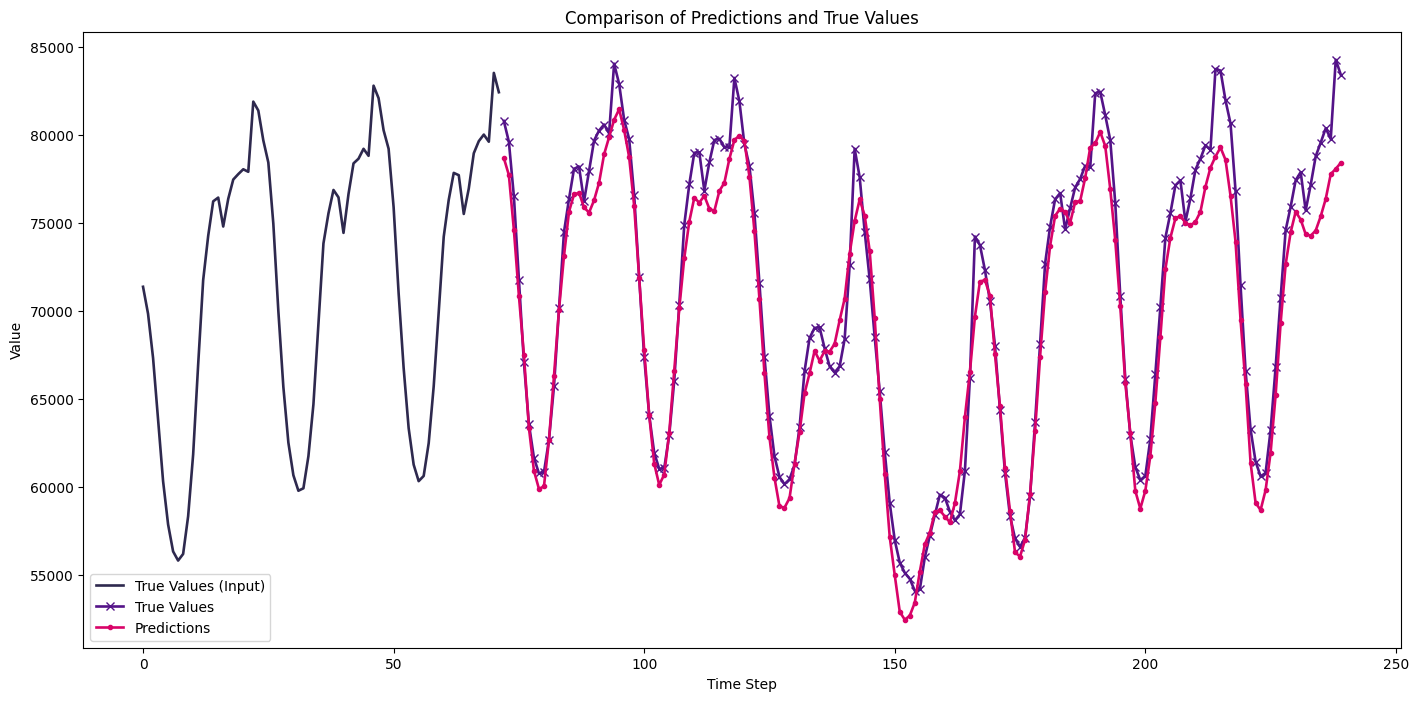

In [30]:
validation_load = total_load[int(n*0.7):]
row = 85
        
inputs_to_model = process_input_data(start_input = row, df = val_df, input_days = INPUT_DAYS, forecast_days = FORECAST_DAYS, steps_per_day= STEPS_PER_DAY)

predictions_raw = model_forecast(inputs_to_model = inputs_to_model,model = lstm_model)

predictions_processed = process_predictions(predictions = predictions_raw, 
                                                    min_values = min_values, 
                                                    max_values = max_values, 
                                                    label_columns=label_columns,
                                                    input_days = INPUT_DAYS, 
                                                    forecast_days = FORECAST_DAYS, 
                                                    steps_per_day = STEPS_PER_DAY, 
                                                    start_input = row)

validation_dict = validate_predictions(predictions_raw=predictions_raw, 
                                                    real_values = validation_load, 
                                                    min_values = min_values, 
                                                    max_values = max_values, 
                                                    label_columns=label_columns, 
                                                    start_input = row, 
                                                    input_days = INPUT_DAYS, 
                                                    forecast_days = FORECAST_DAYS, 
                                                    steps_per_day = STEPS_PER_DAY, 
                                                    validation_dict = validation_dict)

plot_inputs_and_predictions(predictions_processed=predictions_processed,total_load=validation_load,input_days = INPUT_DAYS, forecast_days = FORECAST_DAYS, steps_per_day = STEPS_PER_DAY, window_lenght = WINDOW_LENGHT, row = row)

In [34]:
from settings import FORECAST_DAYS,INPUT_DAYS,STEPS_PER_DAY,WINDOW_LENGHT

validation_dict = {'avg_day_1':[],
                'avg_day_2':[],
                'avg_day_3':[],
                'avg_day_4':[],
                'avg_day_5':[],
                'avg_day_6':[],
                'avg_day_7':[],
                'p_avg_day_1':[],
                'p_avg_day_2':[],
                'p_avg_day_3':[],
                'p_avg_day_4':[],
                'p_avg_day_5':[],
                'p_avg_day_6':[],
                'p_avg_day_7':[],
                'std_avg_day_1':[],
                'std_avg_day_2':[],
                'std_avg_day_3':[],
                'std_avg_day_4':[],
                'std_avg_day_5':[],
                'std_avg_day_6':[],
                'std_avg_day_7':[]
                }

model_validation_dict = {}

model = 'load_forecast_with_temperature_knmodes_10.keras'

print("---------------------------------------------------")
print("Initializing model validation")
print("---------------------------------------------------")

model_path = os.path.join(path,model)
lstm_model = load_model(model_path)

print(f"Model {model} loaded")
print("---------------------------------------------------")

k_nmodes = model_dict[model]

print(f"Initializing feature eng.")
print("---------------------------------------------------")

df = df_raw.copy()
df = ciclical_time_encoding(df = df)
datetime_range = retrieve_and_remove_datetime(df = df)
df = decompose_series_vmd(df = df, timeseries = 'total_load', k_nmodes = k_nmodes)

total_load = df['total_load'].to_list()
df.drop(columns = ['total_load'], inplace = True)
df.drop(columns = ['index'], inplace = True)

n = len(scal_df)
scal_df, min_max_values = split_and_scal_df(df = df)

#Getting only the validation and testing portion of the data
val_df = scal_df[int(n*0.7):]
validation_load = total_load[int(n*0.7):]

# Forecast columns
label_columns = scal_df.columns.to_list()[7:]
print("Scaled DF to be used in the model validation:")
print("")
print(scal_df)
print("---------------------------------------------------")

#Min and max values
min_values = min_max_values[0]
max_values = min_max_values[1]

model_validation_dict[model] = validation_dict

print(f"Initiating {model} validation")
print("---------------------------------------------------")

days_count = 1
for row in range(0, len(val_df), 24):

    if row < (len(val_df) - WINDOW_LENGHT):
        total_days = int(len(scal_df)/24)

        print(f"Validating day {days_count} | Total progress: {np.round((days_count/total_days)*100,2)}%                          ",end = '\r')
                
        inputs_to_model = process_input_data(start_input = row, df = val_df, input_days = INPUT_DAYS, forecast_days = FORECAST_DAYS, steps_per_day= STEPS_PER_DAY)

        predictions_raw = model_forecast(inputs_to_model = inputs_to_model,model = lstm_model)
        
        predictions_processed = process_predictions(predictions=predictions_raw, min_values = min_values, 
                                                            max_values = max_values, 
                                                            label_columns=label_columns,input_days = INPUT_DAYS, 
                                                            forecast_days = FORECAST_DAYS, 
                                                            steps_per_day = STEPS_PER_DAY, 
                                                            start_input = row)

        model_validation_dict[model] = validate_predictions(predictions_raw=predictions_raw, 
                                                            real_values = validation_load, 
                                                            min_values = min_values, 
                                                            max_values = max_values, 
                                                            label_columns=label_columns, 
                                                            start_input = row, 
                                                            input_days = INPUT_DAYS, 
                                                            forecast_days = FORECAST_DAYS, 
                                                            steps_per_day = STEPS_PER_DAY, 
                                                            validation_dict = model_validation_dict[model])
        days_count+=1
    else:
        next

---------------------------------------------------
Initializing model validation
---------------------------------------------------
Model load_forecast_with_temperature_knmodes_10.keras loaded
---------------------------------------------------
Initializing feature eng.
---------------------------------------------------
Decomposing total_load in 10 nmodes
Scaled DF to be used in the model validation:

       temperature  year_sin  year_cos  daily_sin  daily_cos    weekly_sin  \
0         0.260561  0.967027  0.678700   0.830632   0.973511  9.903112e-02   
1         0.219656  0.668801  0.970645   0.840550   0.968872  9.009688e-01   
2         0.192060  0.253055  0.934764   0.850468   0.963745  7.225209e-01   
3         0.163010  0.009233  0.596039   0.860385   0.958252  1.010152e-08   
4         0.142969  0.107084  0.190289   0.870303   0.952393  5.000000e-01   
...            ...       ...       ...        ...        ...           ...   
13171     0.820505  0.331199  0.970645   0.806

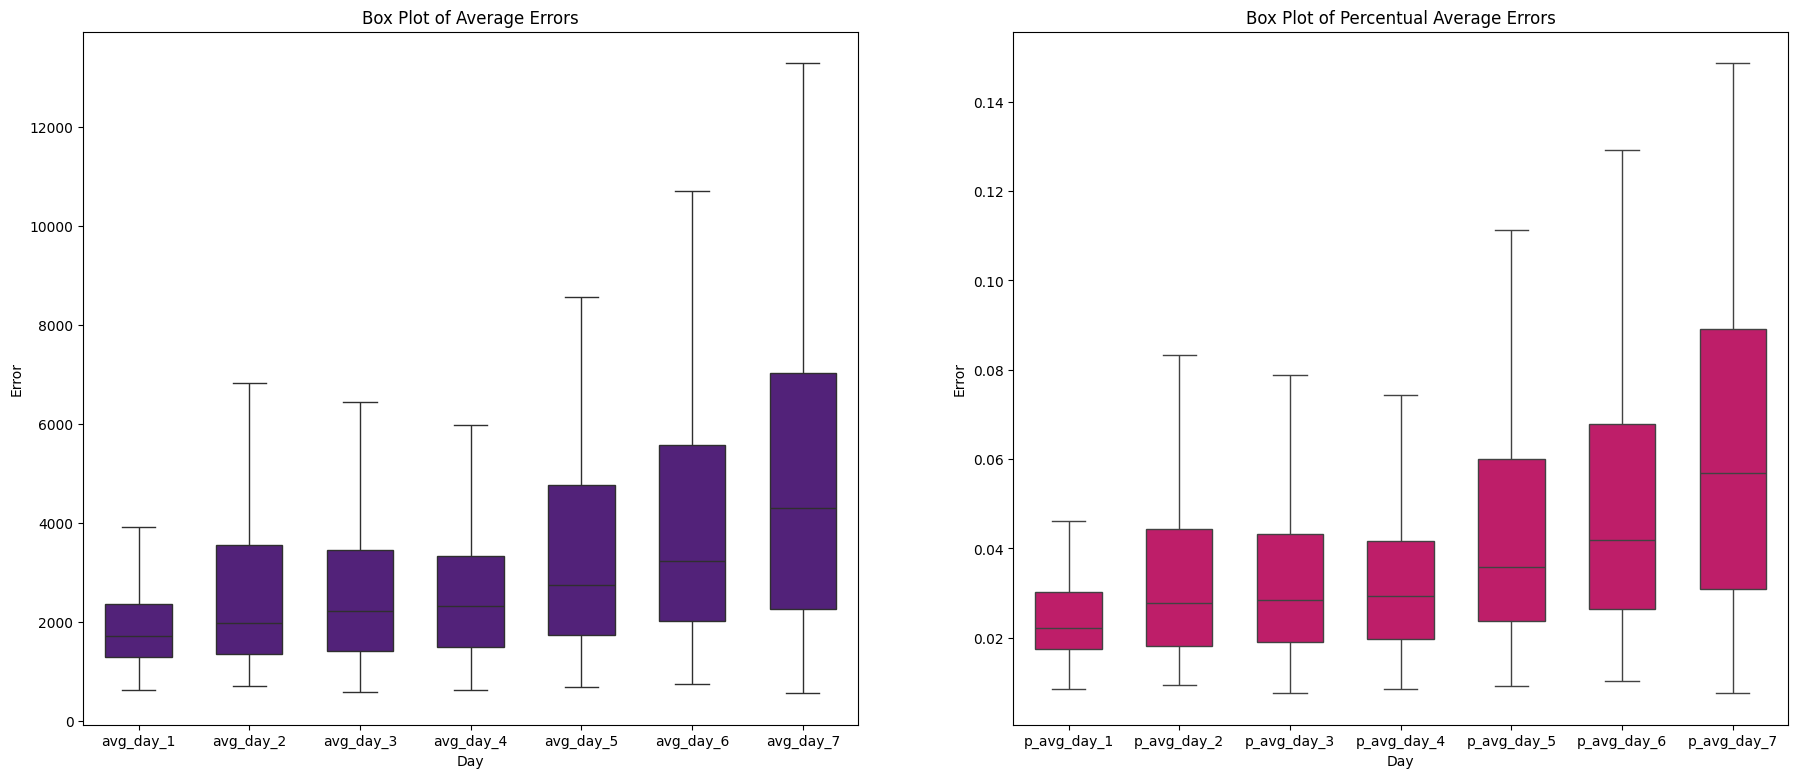

In [35]:
df_avg_plot = pd.DataFrame({k: validation_dict[k] for k in list(validation_dict)[:7]})
df_per_plot = pd.DataFrame({k: validation_dict[k] for k in list(validation_dict)[7:14]})

# Melt the DataFrames to 'long' format for Seaborn
df_avg_melted = df_avg_plot.melt(value_vars=df_avg_plot.columns, var_name='day', value_name='avg_error')
df_per_melted = df_per_plot.melt(value_vars=df_per_plot.columns, var_name='day', value_name='percentual_avg_error')

# Set up the Seaborn plot with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Box plot for average errors
sns.boxplot(x='day', y='avg_error', data=df_avg_melted, showfliers=False, width=0.6, color='#541388', ax=axes[0])
axes[0].set_title('Box Plot of Average Errors')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Error')

# Box plot for percentual average errors
sns.boxplot(x='day', y='percentual_avg_error', data=df_per_melted, showfliers=False, width=0.6, color='#D90368', ax=axes[1])
axes[1].set_title('Box Plot of Percentual Average Errors')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Error')

plt.show()



In [36]:
print("Avg daily error mean")
print(df_avg_plot.mean())

print("-----------------------")
print(f"Avg forecast error mean: {int(df_avg_plot.mean().mean())}")


Avg daily error mean
avg_day_1    1955.544556
avg_day_2    2686.779541
avg_day_3    2693.955566
avg_day_4    2637.411621
avg_day_5    3582.404541
avg_day_6    4057.222656
avg_day_7    5092.282715
dtype: float32
-----------------------
Avg forecast error mean: 3243


In [37]:
print("Avg Percentage daily error mean")
print(df_per_plot.mean()*100)

print("-----------------------")
print(f"Avg Percentage forecast error mean: {np.round(df_per_plot.mean().mean()*100,2)} %")

Avg Percentage daily error mean
p_avg_day_1    2.513132
p_avg_day_2    3.406538
p_avg_day_3    3.452957
p_avg_day_4    3.373758
p_avg_day_5    4.543005
p_avg_day_6    5.121355
p_avg_day_7    6.380476
dtype: float32
-----------------------
Avg Percentage forecast error mean: 4.11 %
